# Backend note
Before running, select a Keras backend in your shell and restart the kernel:
- JAX (default): `export KERAS_BACKEND=jax` and `pip install -r requirements-jax.txt`
- PyTorch: `export KERAS_BACKEND=torch` and `pip install -r requirements-torch.txt`
You can verify inside Python with:
`import keras; print(keras.backend.backend())`

### Quickstart Tutorial

Hi! Welcome to $\texttt{stella}$, a package to identify stellar flares using $\textit{TESS}$ two-minute data. Here, we'll run through an example of how to create a convolutional neural network (CNN) model and how to use it to predict where flares are in your own light curves. Let's get started!

In [1]:
import os, sys
import stella
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(
/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/benpope/.lightkurve/cache. Please move all the files in the legacy directory /Users/benpope/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


#### 1.1 Download the Models

For this network, we'll be using the models created and used in Feinstein et al. (2020). The models can be downloaded from MAST using the following:

In [22]:
# ds = stella.DownloadSets()
# ds.download_models()

In [23]:
from glob import glob 
home = os.path.expanduser("~")
pattern = home + "/Dropbox/keras/*.keras"
MODELS = glob(pattern, recursive=True)
MODELS

['/Users/benpope/Dropbox/keras/ensemble_s0005_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0078_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0018_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0080_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0029_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0028_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0050_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0038_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0004_i0350_b0.73_savedmodel.keras',
 '/Users/benpope/Dropbox/keras/ensemble_s0077_i0350_b0.73_savedmodel.keras']

#### 1.2 Using the Models

Step 1. Specifiy a directory where you'd like your models to be saved to. 

In [24]:
OUT_DIR = './results/'

Step 2. Initialize the class! Call $\texttt{stella.ConvNN()}$ and pass in your directory. A message will appear that says you can only call $\texttt{stella.ConvNN.predict()}$. That's okay because we're doing to pass in the model later down the line.

In [25]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


The easiest thing you can do is pass in your light curves here! Let's grab an example star using $\texttt{lightkurve}$:

/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_10164/1683112778.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc.download().PDCSAP_FLUX


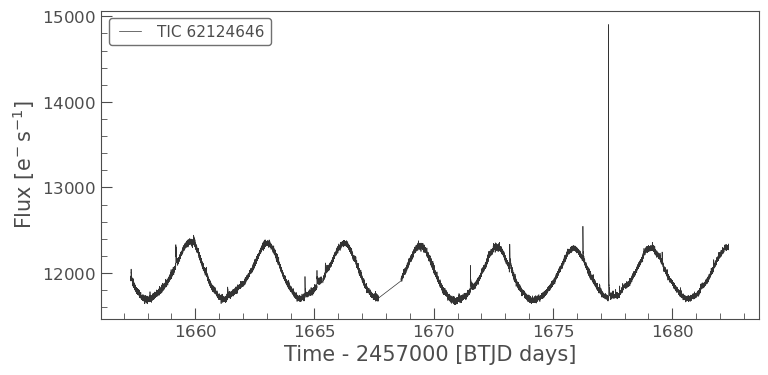

In [ ]:
#### create a lightkurve for a two minute target here for the example
from lightkurve.search import search_lightcurve

lc = search_lightcurve(target='TIC 62124646', mission='TESS', sector=13, exptime=120)
lc = lc.download().PDCSAP_FLUX
lc.plot();

Now we can use the model we saved to predict flares on new light curves! This is where it becomes important to keep track of your models and your output directory. To be extra sure you know what model you're using, in order to predict on new light curves you $\textit{must}$ input the model filename.

In [29]:
cnn.predict(modelname=MODELS[0],
            times=lc.time.value, 
            fluxes=lc.flux.value, 
            errs=lc.flux_err.value)
single_pred = cnn.predictions[0]

  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


You can inspect the model a bit more by calling `cnn.model.summary()` which details the layers, size, and output shapes for the $\texttt{stella}$ models.

In [30]:
cnn.model.summary()

Model: "stella_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 16)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       102,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,729 (413.00 KB)

 Trainable params: 105,729 (413.00 KB)

 Non-trainable params: 0 (0.00 B)

Et voila... Predictions!

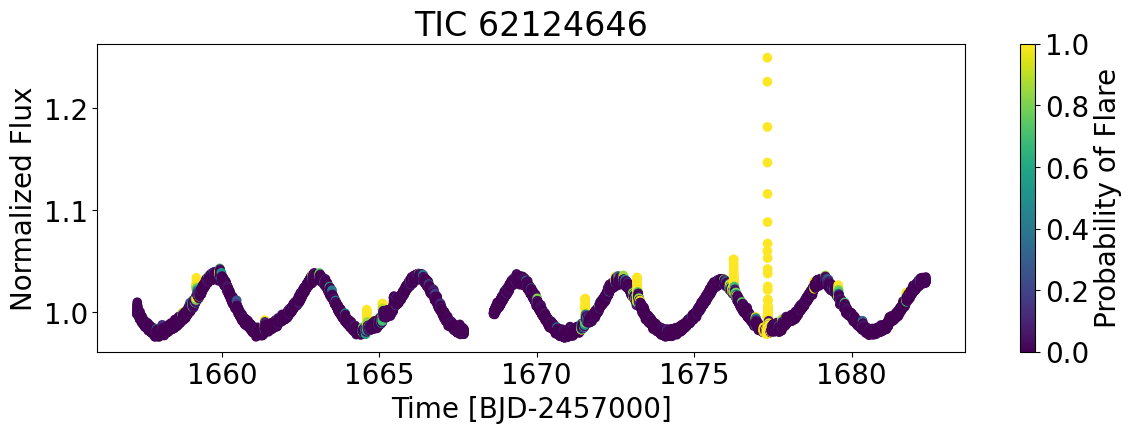

In [33]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid))
plt.show();

Now you can loop through all 10 models provided and average over the predictions from each model. This is called $\textit{ensembling}$ and can provide more accurate predictions than using a single model.

In [36]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time.value,
                fluxes=lc.flux.value,
                errs=lc.flux_err.value)
    preds[i] = cnn.predictions[0]
    
avg_pred = np.nanmedian(preds, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step


  0%|          | 0/1 [00:00<?, ?it/s]

532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


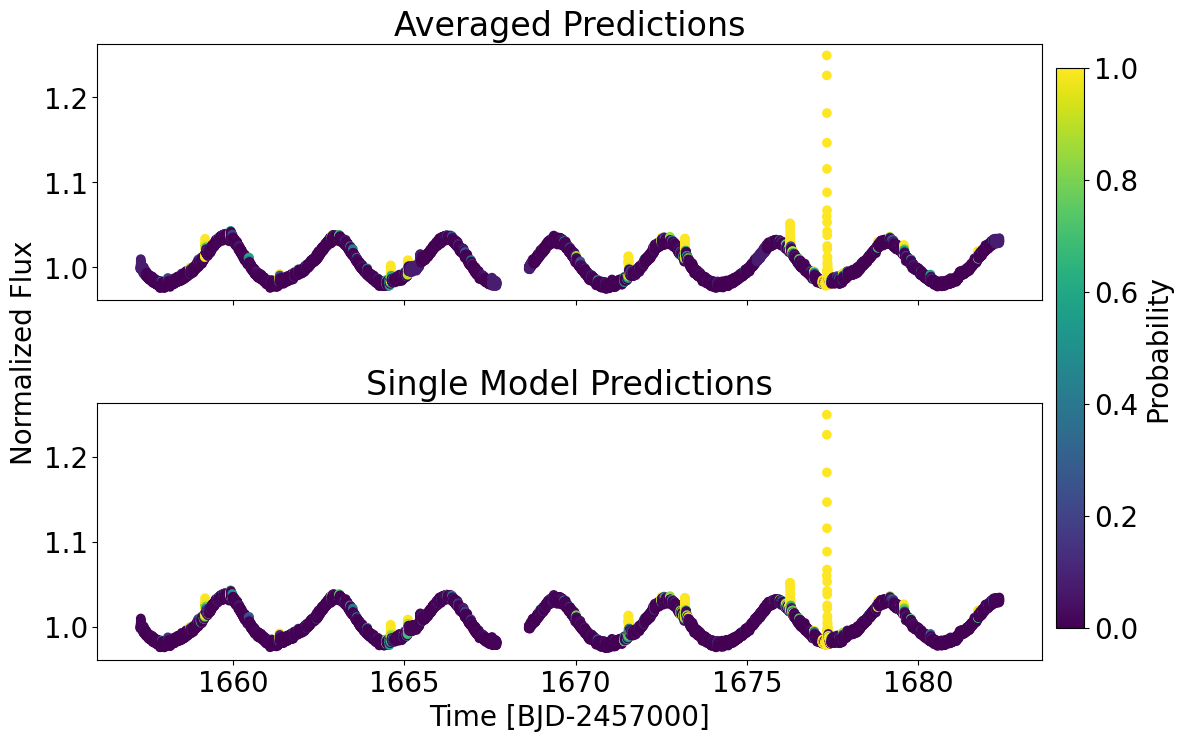

In [41]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4)

plt.show();

There might not be a huge noticeable difference here, but if we zoom into a noisier region and look at both the light curves and the predictions over time, we see that the averaged values do a better job at marking a lower probability for these regions. (It should also be noted that using the `stella.FitFlares()` function, these potential flares are not marked as real. See [Other Fun Features](http://adina.feinste.in/stella/getting_started/other_features.html) for a demo on this class.) 

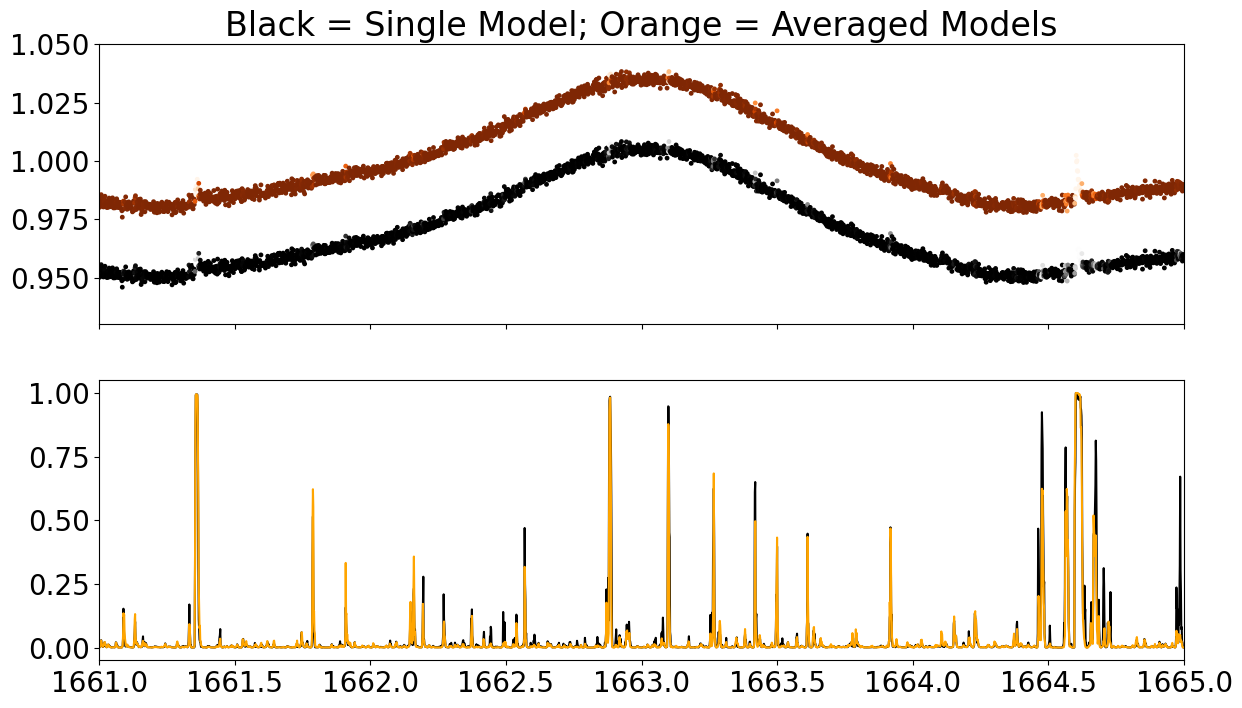

In [42]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

plt.xlim(1661,1665)
plt.show();